In [1]:
import numpy as np
import stressfit.shapes as S
import stressfit.mccfit as mc
import stressfit.commands as comm
from IPython.display import HTML
deg = np.pi/180.
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>To hide/show the code blocks, click <a href="javascript:code_toggle()">here</a>.</b>''')

# STRESSFIT
<p>
<i>Written by:</i> Jan Saroun, Nuclear Physics Institute CAS, Rez, saroun@ujf.cas.cz<br/>
<i>Date:</i> 03/20/2023<br/>
<i>Source:</i> <a href='https://github.com/NPLtools/stressfit'>https://github.com/NPLtools/stressfit</a>
</p>
<p>
This script implements common workflow for the data treatment with StressFit. On the input, STRESFIT uses a list of neutron scattering events with associated data (position, wave vectors, weight factor and "as-measured" lattice spacing - $d_{hkl}$}) accessible at given instrument setup. This list describes the instrumental sampling distribution independently on the sample. It can be obtained by ray-tracing simulation of the instrument using appropriate software, such as McStas (<a href='http://mcstas.org'>http://mcstas.org</a>) or SIMRES (<a href='https://github.com/saroun/simres'>https://github.com/saroun/simres</a>). 

STRESSFIT provides tools for 3D convolution of such a sampling list with the sample model and permits to calculate: 

- “centre of gravity” and size of the neutron sampling volume as a function of sample position (in 3D),
- variation of intensity and position of diffraction peaks due to the perturbation of sampling distribution (material boundaries, absorption, composition and texture gradients),
- “as measured” (smeared) intensity and strain distributions including the pseudo-strain effects,
- least-squares fit of intrinsic strain and intensity distributions.

</p><p>
STRESSFIT enables to model pseudo-strains for several sample shapes such as curved plates, cylinders, spheres, tubes (both single- and multi-channel) and polygonal rods. Neutron attenuation tables for several common materials generated with the help of the NCrystal library (<a href='https://github.com/mctools/ncrystal'>https://github.com/mctools/ncrystal</a>) are provided as a part of the package resources. Currently, STRESSFIT allows for least squares fitting of measured scans for a single strain component. Simultaneous fitting of multiple strain or stress tensor components is envisaged in future versions.
</p>    

## Jupyter viewer

User interface based on Jupyter notebook widgets can be launched by executing the code:
<code>  
import stressfit.ui.notebook as nb  
ui = nb.UI()  
ui.display()  
</code> 
    
Script examples with output of STRESSFIT are also available via Jupyter viewer server:
<p>
<a href='http://nbviewer.jupyter.org/url/neutron.ujf.cas.cz/restrax/download/stressfit/stressfit_example1.ipynb'>
Example 1</a>: ECNS2019, Fitting of strain gradient under the inner surface of a tube, test on synthetic data for STRESS-SPEC.
</p>

## Documentation
<p>
For more information and use examples, see: <br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/ECRS2018_stressfit.pdf'>ECRS10, 2018, slides</a><br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/saroun_ECNS2019_poster.pdf'>ECNS 2019, poster</a> <br/>
<a href='http://neutron.ujf.cas.cz/restrax/download/stressfit/stressfit_ECNS2023_poster.pdf'>ECNS 2023, poster</a> <br/>
</p>

In [2]:
# Set the workspace directory. None for the current directory.
workspace = None
# workspace = r'my_workspace_root'
# Set the other input/output folders (can be absolute or relative).
# Relative paths should exist under the workspace directory.
# Set to None for searching in package resources.
output_path = './output' # output data
input_path = None # input data
tables_path = None # lookup tables etc.
sampling_path = None # directory with simulated sampling points 

# Set workspace and validate
comm.set_workspace(workspace)
comm.set_environment(data=input_path, output=output_path, tables=tables_path)
comm.validate_workspace()

Loaded workspace setting from C:\Users\Honza\Documents\stressfit\.stressfit\workspace.json


## Sample definition
Following block defines the <b>sample shape, position and orientation.</b>
### Coordinates
The laboratory frame is defined by y-axis vertical and z-axis pointing along the incident beam.
The positioning includes rotation by YXY Euler angles ($\omega$, $\chi$, $\phi$) and a linear shift (multiple commands <code>rotate</code> and <code>moveTo</code> are possible to achieve required position).

Imported MC events are defined in the laboratory frame, with the origin at the centre of the instrumental gauge volume. Sample position and orientation thus define zero scan position and scan direction in the sample.

### Sample shape
Sample dimensions depend on the selected shape. Choose one of the classes defined in the Shapes folder of the package:

<code> S.create('Plate', thickness=10.0) </code> <br />
An infinitely large flat plate of given thickness.

<code> S.create('PlateCurved',thickness=5.0, length=50.0, height=15.0, rho1=[0.02, 0.0], rho2=[0.02, 0.0]) </code><br />
A curved plate of given thickness (z), length (x) and height (y). <code>rho1</code> are curvature radii along x and y of the front surcae (z>0). <code>rho2</code> are the radii for the rear surface.

<code> S.create('Cylinder', radius=4.0, height=30.0) </code><br />
A cylindrical shape with axis along y-axis.

<code> S.create('Tube', Rin=4.0, Rout=8.0, height=30.0, ctr=[0,0], sref=1) </code><br /> 
A hollow cylinder with axis along y-axis. 
- Rin, Rout are the inner and outer radii.
- ctr is the x,z position of the hole centre
- sref defines the reference surface for depth calculation (0/1 for the inner/outer surface)

<code> S.create('Sphere', radius=8.0) </code> <br />
A spherical sample.

<code> S.create('ETubes', a=8.0, b=8.0, angle=0.0, height=30.0, holes=[], sdir=[0,0,1], sctr=[0,0,0]) </code><br />
A cylinder with axis || y and multiple coaxial elliptic holes.

    a : float
        First semi-axis of the sample basis, parallel to x if angle=0. 
    b : float
        Second semi-axis of the sample basis, parallel to z if angle=0.  
    angle : float
        Angle of the semiaxis a with respect to x [deg]
    height : float
        Height in [mm].
    holes : list of dict
        Each item defines a hole. 
        The parameters are
            x, z : coordinates of the centre
            a, b : ellipse semi-axes
            angle : angle of the semiaxis a with respect to x [deg].
    sdir : array_like
        Scan direction in local coordinates.
    sctr : array_like
        Scan origin in local coordinates. 

### Input data
The input experimental data are integral peak intensities and strains measured as a function of scan depth. They are provided as text files with three columns: depth [mm], intensity [any unit] or strain [$\mu\epsilon = 10^{-6}$], and error (std. deviation). 



## User input
The next block in this template defines a tube: a hollow cylinder with inner radius 4 mm, outer radius 8 mm and height 50 mm. Zero scan position corresponds to the instrumental gauge volume centered at the surface. Measured strain direction is defined by the angle <code>omega</code>.

In [4]:
# USER INPUT:

# Create sample shape (see comment above).
# Dimensions [mm]
radius1 = 4.
radius2 = 8
height = 50.0
shape = S.create('Tube', Rin=4.0, Rout=8.0, height=50.0)

# Define input data for measured strain and intensity
# 3-column text format with scan position, value and error
strain = 'eps_SS_rad.dat'
intensity='int_SS_rad.dat'

# Define scan geometry
# Scan direction in sample coordinates (where the gauge moves)
scandir=[0., 0., -1.]
# Sample orientation (Euler angles YXY) in deg
angles=[135, 0, 0]
# Scan origin (encoder = 0) in sample coordinates
scanorig=[0, 0, 0]
# Sample rotation centre (sample coordinates)
rotctr=[0, 0, 0]

# Define material attenuation, either of:
# File name: A table with 2 columns: wavelength [A], attenuation [1/cm]
# Float number: attenuation [1/cm]:
att = 'Fe_mu.dat'

# file with the sampling points  
sampling_file = 'events_S_1mm.dat' 
# number of sampling points to load from the file
nev_load = 3000
# number of sampling points to plot
nev_plot = 3000
# number of sampling points to use in concolution
nev_use = 3000

# 2D plot of experiment geometry:
# scene width,height in [mm]
scene_range = [16, 16]  
# projection plane (zy=0, xz=1, xy=2)
scene_projection = 1 

## Initialization commands

In [5]:


# Load the data and save it in the scan variable with all meta-data. 
scan = comm.load_input(strain, intensity=intensity,scandir=scandir,
                       scanorig=scanorig, rotctr=rotctr, angles=angles)

# Load and set sampling distribution
sampling = comm.load_sampling(sampling_file, path=sampling_path, maxn=nev_load)
sampling.print_properties()
comm.set_sampling(sampling)

# Set beam attenuation
comm.set_attenuation(att)    

# Set sample shape
comm.set_shape(shape)

# Set experiment geometry 
comm.set_scan(scan)   

File loaded: c:\saroun\publikace\2023\ecns2023\stressfit-master\stressfit\resources\data\eps_SS_rad.dat
File loaded: c:\saroun\publikace\2023\ecns2023\stressfit-master\stressfit\resources\data\int_SS_rad.dat
Number of loaded sampling points: 3000
Gauge centre: [0.000381133, -0.0376984, -0.0568796] 
Mean wavelength: 1.68024
2 theta: 91.8022
d0: 1.16986

File loaded: C:\Users\Honza\Documents\stressfit\tables\Fe_mu.dat


## Sampling distribution

The following command plots the sample and sampling events in requested projection. The <b>red arrow defines the scan direction</b> (where the events move in the sample during the scan). The color scale shows pseudo-strains associated with each event.

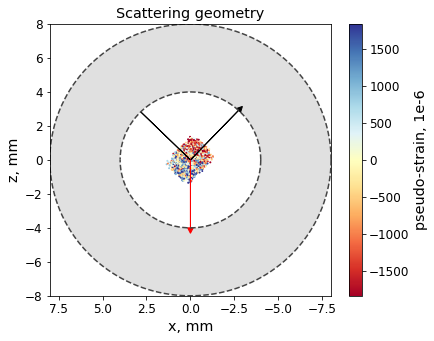

In [6]:
comm.plot_scene(nev_plot, scan=scan['epsfile'], rang=scene_range, proj=scene_projection)


## Fit intensities
Fitting of intensities allows to determine the variation of scattering probability and extinction with scan depth. It can also help to correct for any missfit between the encoder positions (stored in the data file) and true surface position. Note that sometimes these effects can't be distinguished from each other. With a strong variation of scattering probability (e.g. due to a greadient in texture or composition near the surface), it is not possible to reliably determine the surface position and extinction just from the intensity variation. Then some of the parameters must be determined independently and fixed for fitting. On the other hand, it is the product of extinction and scattering probability distributions which affects pseudo-strains, therefore they do not need to be exactly distinguished.

NOTE:<br/>
Scattering probability and strain distributions are defined on the depth scale. Definition of the <i>depth</i> depends on the sample shape. For plates, it is the distance to the upper surface (in local coordinates of the sample). For sphers and cylinders, it is the distance from the curved surface (the outer one in the case of hollow shapes). For complex samples like ETubes, the 'depth' is a position inside the sample projected on the scan direction.

### Define initial values

The depth distributions are modelled as a set of points interpolated by splines of selected order (1 to 3). Define below a minimum number of depth and intensity values which gives a satisfactory estimate of the intensity variation. Obviously, the intensity values should be kept constant for homogeneous materials.

<b>Provide the fit model settings below:</b>

Check the fit estimate and iprove the model if necessary:


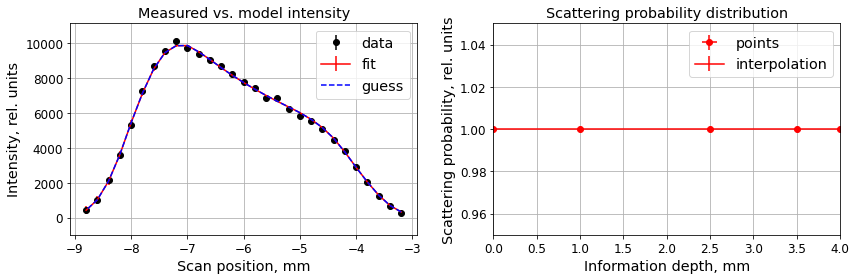

In [7]:
# USER INPUT for intensity fit 
#--------------------------------------------------------------------
# Give initial values, followed by flags (0|1), fx=1 means a free variable, 0 for fixed. 

# depth values [mm]
x =  [0., 1., 2.5, 3.5, 4]
fx = [0, 0, 0, 0, 0]

# intrinsic scattering intensity [rel. units]
y = [1., 1.0, 1.0, 1., 1.]
fy = [0, 0, 0, 0, 0]

# Set the method for interpolation between the nodes.
# Use one of 'natural','clamped', 'PCHIP', 'Akima'
interpolation = 'PCHIP' # PCHIP = Piecewise cubic Hermitian interpolation polynomial

# Background and amplitude
A = 33000
B = 0
# fixed (0) or free (1):
fA = 1
fB = 0

# zero encoder position = position of the front surface in encoder scale
# = where is the surface position in the data table ...
zc = 0.05
# fixed (0) or free (1):
fzc = 1

# Define fit options
# Maximum number of iterations
maxiter = 100
# Use bootstrap method for estimation of confidence limits?
bootstrap = False
# Set loops for the number of bootstrap cycles.
loops = 3
# regularization
areg = 3
# Set False to skip intensity fit
runIFit = True

#---------------------------------------------------------------------
# Guess fit
# If necessary, adjust the above parameters to improve the initial model.
#----------------------------------------------------------------------
ifit = comm.define_ifit(scan, [x,y,fx,fy], nev_use)

# define scaling (background, amplitude and depth shift). minval,maxval=limits of these parameters.
ifit.defScaling([A, B, zc], [fA, fB, fzc], minval=[0., 0., -np.inf])
# set the interpolation method
ifit.setInterpModel(interpolation)

# Run guess fit with given parameters (see docs for run_fit_guess)
if runIFit:
    print('Check the fit estimate and iprove the model if necessary:')
    comm.run_fit_guess(ifit, maxiter=100, ar=areg, outname='')
    

### Run fit
Is the above estimate good? Then execute the following box to run fitting procedure and plot results.

Starting fit for < 100 iterations.
iter=0, chi2=22.3942, reg=0
iter=7, chi2=22.3659, reg=3.55271e-08
iter=11, chi2=22.361, reg=1.06581e-07
iter=13, chi2=22.361, reg=3.55271e-08
iter=15, chi2=22.358, reg=7.10543e-08
iter=17, chi2=22.358, reg=3.55271e-08
iter=19, chi2=22.3534, reg=3.55271e-08
iter=21, chi2=22.3534, reg=7.10543e-08
Finished: FoM=22.3534, chi2=22.3534, reg=7.10543e-08


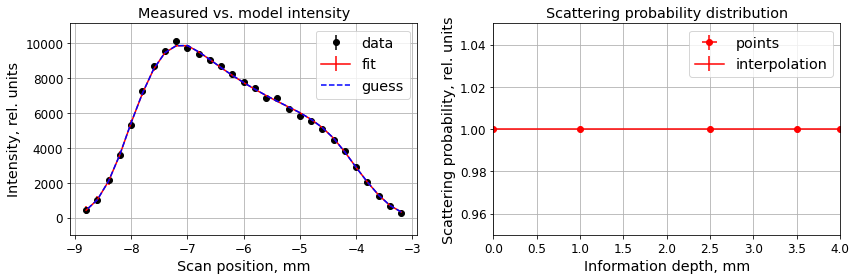

Figure saved in C:\Users\Honza\Documents\stressfit\output\int_SS_rad_fit.png
Model saved in C:\Users\Honza\Documents\stressfit\output\int_SS_rad_model.dat
Fit saved in C:\Users\Honza\Documents\stressfit\output\int_SS_rad_fit.dat
Log saved in C:\Users\Honza\Documents\stressfit\output\int_SS_rad.log


In [8]:
if runIFit:
    comm.run_fit(ifit, maxiter=maxiter, ar=areg, bootstrap=bootstrap, 
                 loops=loops, outname=scan['intfile'])

## Fit strain distribution
Fitting of strain depth distribution is similar to the above procedure for fitting intensities. The scattering probability distribution determined above will be automatically taken into account in modelling of pseudo-strains below.

### Define initial values

The depth distributions are modelled as a set of points [depth, $\epsilon$(depth)] interpolated by splines of selected order (1 to 3). Define below a minimum number of depth and strain values which gives a satisfactory estimate of the strain distribution. 

<b>Provide the fit model settings below:</b>

Using surface position: 0.0501903



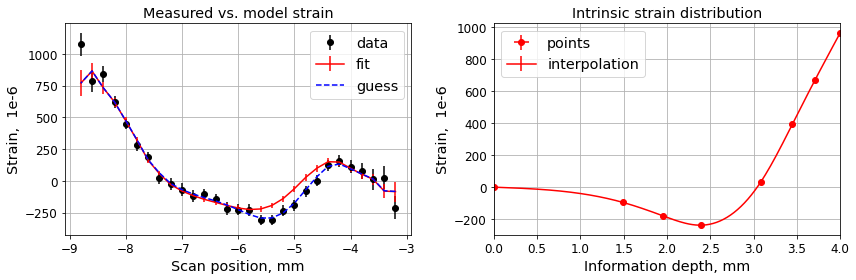

In [9]:
# USER INPUT for strain fit 
#--------------------------------------------------------------------
# Give initial values, followed by flags (0|1), fx=1 means a free variable, 0 for fixed. 
# initial depth values [mm]
x =  [0., 1., 2.0 , 2.5, 3.0 , 3.5 , 3.7 ,  4.]
fx = len(x)*[1]
fx[0] = 0
fx[-1] = 0

# initial strain values [1e-6]
y =  len(x)*[0.]
fy = len(y)*[1]
fy[0]=0

# Set the method for interpolation between the nodes.
# Use one of 'natural','clamped', 'PCHIP', 'Akima'
# PCHIP = Piecewise cubic Hermitian interpolation polynomial
interpolation = 'natural'  

# Define a constraint function (optional)
def constraint(params):
    """Constraint function."""
    # constraint example: keeps surface strain at 0 with 50ue tolerance
    dist = mc.params2dist(params)
    y=dist[1,1]
    return (y-0.)/50. 
# Assign constraint to constFnc in order to use it:
# constFnc=constraint
constFnc=None

# Define fit options
# Use bootstrap method for estimation of confidence limits?
bootstrap = True
# Set loops for the number of bootstrap cycles.
loops = 5
# Define a list of regularization factors:
aregs = [1, 2, 3, 4, 5]
# maximum iterations for guess fit
maxguess = 100
# maximum iterations for fit
maxiter=200
# Run regularization loop?
runReg = False
# Run strain fit?
runSFit = True

#---------------------------------------------------------------------
# Guess fit
# If necessary, adjust the above parameters to improve the initial model.
#----------------------------------------------------------------------
# use surface position from intensity fit
zc = ifit.params['xc'].value
print('Using surface position: {:g}\n'.format(zc))

sfit = comm.define_sfit(scan, [x,y,fx,fy], nev_use, z0=zc, constFnc=constFnc)

# define interpolation method
sfit.setInterpModel(interpolation)

# Run guess fit with given parameters (see docs for run_fit_guess)
if runSFit:
    comm.run_fit_guess(sfit, maxiter=maxguess, ar=areg, outname='')

## Run fit

Is the above estimate good? Then continue by running the whole fitting job. 

The setting provided above defines the process:

- A bootstrap cycle, if defined, is applied to estimate confidence limit.
- A regularization cycle for given number of are coefficients is executed if requested. 

In [11]:
# Run fit with regularization
if runSFit and runReg:
    comm.run_fit_reg(sfit, maxiter=maxiter, ar=aregs, outname='')

### Run the final fit

Choose the optimum value of <code>areg</code> (regularization coefficient) and run the command below.

Starting fit for < 200 iterations and 5 loops for error estimate.
iter=0, chi2=2.35014, reg=4.23481e+06
iter=2, chi2=2.35014, reg=4.23481e+06
iter=5, chi2=2.35014, reg=4.23481e+06
iter=16, chi2=1.35705, reg=7.05247e+06
iter=17, chi2=1.35705, reg=7.05247e+06
iter=19, chi2=1.35705, reg=7.05247e+06
iter=23, chi2=1.35705, reg=7.05247e+06
iter=25, chi2=1.35705, reg=7.05247e+06
iter=28, chi2=1.35705, reg=7.05247e+06
iter=29, chi2=1.35705, reg=7.05247e+06
iter=31, chi2=1.3503, reg=6.85067e+06
iter=32, chi2=1.3503, reg=6.85067e+06
iter=34, chi2=1.3503, reg=6.85067e+06
iter=35, chi2=1.3503, reg=6.85067e+06
iter=38, chi2=1.3503, reg=6.85067e+06
iter=43, chi2=1.3503, reg=6.85067e+06
iter=44, chi2=1.3503, reg=6.85067e+06
iter=46, chi2=1.34818, reg=6.83428e+06
iter=47, chi2=1.34818, reg=6.83428e+06
iter=49, chi2=1.34818, reg=6.83428e+06
iter=50, chi2=1.34818, reg=6.83428e+06
iter=58, chi2=1.34818, reg=6.83428e+06
iter=59, chi2=1.34818, reg=6.83428e+06
iter=60, chi2=1.3475, reg=6.83446e+06
iter=61, 

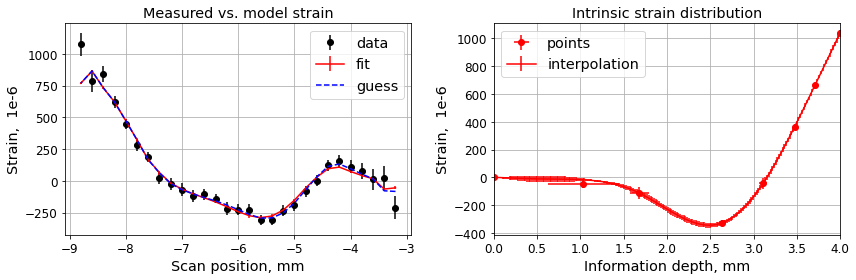

Figure saved in C:\Users\Honza\Documents\stressfit\output\eps_SS_rad_fit.png
Model saved in C:\Users\Honza\Documents\stressfit\output\eps_SS_rad_model.dat
Fit saved in C:\Users\Honza\Documents\stressfit\output\eps_SS_rad_fit.dat
Log saved in C:\Users\Honza\Documents\stressfit\output\eps_SS_rad.log


In [12]:
areg = 2.5
if runSFit:
    comm.run_fit(sfit, maxiter=maxiter, ar=areg, outname=scan['epsfile'], 
                 bootstrap=bootstrap, loops=loops)
